# **Correlation between Venues in Toronto Neighborhoods and Covid-19 Transmission**

## Table of contents
* [Introduction: Business Problem](#Introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="Introduction"></a>

2020 has been a very special year due to the Covid-19 pandemic. This contagious virus can cause mild to moderate respiratory illness and recover without requiring special treatment. However, older people, and those with underlying medical problems are more likely to develop serious illness. Till December 30, 2020 there are totally 572982 Covid-19 cases and costed 15472 lives in Canada. Ontario has the second highest total cases (178831) among all provinces and Toronto has 60000 cases since the beginning of pandemic. This report is trying to answer following question:  
#### **Is there any correlation between venues in Toronto neighborhoods and Covid-19 transmission?**

Everyone live in Toronto area could be interested in the answer of this problem, especially decision makers in government.

## Data <a name="data"></a>

Install packages needed for this notebook.

In [2]:
# Install geopy
#!conda install -c conda-forge geopy --yes
# Install folium
#!conda install -c conda-forge folium=0.5.0 --yes
# install geojson
#!pip install geojson
# install area for neighborhood area calculation
#!pip install area
import pandas as pd
import numpy as np
import os
import json
from area import area
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import requests # library to handle requests
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

### Statistics of Covid-19 cases in Toronto as of Dec 22  
Website: https://www.toronto.ca/home/covid-19/covid-19-latest-city-of-toronto-news/covid-19-status-of-cases-in-toronto/  
Datalink: https://drive.google.com/file/d/1jzH64LvFQ-UsDibXO0MOtvjbL2CvnV3N/view  
Second tab named “All cases and Rates by Neighbou” is used as data source.  
#### Features:  
**Neighbourhood ID:** Unique ID assigned to neighborhood  
**Neighbourhood Name:** Name of neighborhood  
**Rate per 100,000 people:** Number of Covid-19 cases for every 100,000 people in neighborhood  
**Case Count:** Total number of cases in neighborhood  

#### Data Cleansing

Since the dataset is in csv format, let's read it into pandas dataframe and assign preferable names to features.

In [2]:
#read Toronto Covid case count per neighborhood into pandas dataframe
raw = pd.read_csv('COVID-19_Neighbour.csv')
raw.columns=['ID', 'Neighborhood', 'Rate_per_100k', 'Case']
raw=raw.sort_values('ID')
raw=raw.dropna()
raw['ID']=raw['ID'].astype('int')
raw

ID                       Neighborhood  Rate_per_100k  Case
76    1             West Humber-Clairville    4385.806916  1461
66    2  Mount Olive-Silverstone-Jamestown    5192.085938  1711
88    3       Thistletown-Beaumond Heights    5347.490347   554
63    4                    Rexdale-Kipling    3172.191091   334
54    5                   Elms-Old Rexdale    2887.055838   273
..  ...                                ...            ...   ...
75  136                          West Hill    2007.885514   550
8   137                             Woburn    2989.623259  1599
0   138                      Eglinton East    2493.853179   568
91  139                Scarborough Village    3779.000239   632
41  140                          Guildwood    2531.007361   251

[140 rows x 4 columns]

Calculate population of each neighborhood.

In [3]:
cases=raw.set_index('ID')
cases['Population']=round(cases['Case']/cases['Rate_per_100k']*100000)
cases

Neighborhood  Rate_per_100k  Case  Population
ID                                                                     
1               West Humber-Clairville    4385.806916  1461     33312.0
2    Mount Olive-Silverstone-Jamestown    5192.085938  1711     32954.0
3         Thistletown-Beaumond Heights    5347.490347   554     10360.0
4                      Rexdale-Kipling    3172.191091   334     10529.0
5                     Elms-Old Rexdale    2887.055838   273      9456.0
..                                 ...            ...   ...         ...
136                          West Hill    2007.885514   550     27392.0
137                             Woburn    2989.623259  1599     53485.0
138                      Eglinton East    2493.853179   568     22776.0
139                Scarborough Village    3779.000239   632     16724.0
140                          Guildwood    2531.007361   251      9917.0

[140 rows x 4 columns]

In [4]:
cases.dtypes

Neighborhood      object
Rate_per_100k    float64
Case               int64
Population       float64
dtype: object

### GEOJSON file for neighborhoods in Toronto  
Website: https://open.toronto.ca/dataset/neighbourhoods/  
GEOJSON file is used to:  
(1) Obtain coordinates for each neighborhood. Coordinates are used to obtain venues of neighborhoods from Foursquare.  
(2) Calculate area of each neighborhood. The area of each neighborhood will define the radius passed to Foursquare venues explore API.  
(3) Plot choropleth map of Toronto.  

#### Data Cleaning

Since the dataset is in GEOJSON format, let's read it into pandas dataframe and assign preferable names to features.

In [5]:
# load geojson file as json format
with open ('Neighbourhoods.geojson') as f:
    NB_raw= json.load(f)

In [6]:
# Create pandas dataframe
NB=pd.DataFrame(columns=['AREA_SHORT_CODE','AREA_NAME', 'geometry'])
# Specify features to be extracted from geojson file
frames=[pd.DataFrame([[feature['properties']['AREA_SHORT_CODE'], 
                       feature['properties']['AREA_NAME'], 
                       feature['geometry']['coordinates'][0]]], 
                     columns=['ID','AREA_NAME', 'geometry']) for feature in NB_raw['features']]
# Extract features into dataframe NB
NB=pd.concat(frames)
# Use neighborhood ID as index
NB=NB.sort_values('ID').set_index('ID')

In [7]:
NB.head()

AREA_NAME  \
ID                                          
1              West Humber-Clairville (1)   
2   Mount Olive-Silverstone-Jamestown (2)   
3        Thistletown-Beaumond Heights (3)   
4                     Rexdale-Kipling (4)   
5                    Elms-Old Rexdale (5)   

                                             geometry  
ID                                                     
1   [[-79.55235701287411, 43.7094692811074], [-79....  
2   [[-79.6033810657499, 43.7578610616191], [-79.6...  
3   [[-79.5775147918291, 43.7338354191899], [-79.5...  
4   [[-79.5551162536014, 43.7151024596992], [-79.5...  
5   [[-79.5551162536014, 43.7151024596992], [-79.5...

Since the GEOJSON file doesn't contain postalcode of each neighborhood, average of coordinates in 'geometry' feature is used as longitude and latitude of each neighborhood as a approximation.  
Area package is used to calculate the area of each neighborhood.

In [8]:
# create list to store coordinates and area of each neighborhood
temp_ll=[]
# itterate through all neighborhoods and calculate mean coordinates and area of neighborhood
for i in NB['geometry']:
    # convert data in geometry to pd dataframe
    temp=pd.DataFrame(i)
    # create object contain type and coordinates for area package
    obj ={'type':'Polygon','coordinates': [i]}
    # Store mean coordinates and area to list
    temp_ll.append(pd.DataFrame([[temp.mean()[0],temp.mean()[1], area(obj)]]))
# convert list to dataframe
ll=pd.concat(temp_ll, ignore_index=True)
ll.columns=['LONGITUDE', 'LATITUDE', 'AREA_M2']
# change index to match NB dataframe
ll.index +=1

In [9]:
#Combine NB and ll
NB_LL=NB.join(ll)
NB_LL.head()

AREA_NAME  \
ID                                          
1              West Humber-Clairville (1)   
2   Mount Olive-Silverstone-Jamestown (2)   
3        Thistletown-Beaumond Heights (3)   
4                     Rexdale-Kipling (4)   
5                    Elms-Old Rexdale (5)   

                                             geometry  LONGITUDE   LATITUDE  \
ID                                                                            
1   [[-79.55235701287411, 43.7094692811074], [-79.... -79.589871  43.706841   
2   [[-79.6033810657499, 43.7578610616191], [-79.6... -79.582169  43.748521   
3   [[-79.5775147918291, 43.7338354191899], [-79.5... -79.558386  43.737719   
4   [[-79.5551162536014, 43.7151024596992], [-79.5... -79.565492  43.725827   
5   [[-79.5551162536014, 43.7151024596992], [-79.5... -79.547033  43.723417   

         AREA_M2  
ID                
1   3.016924e+07  
2   4.641235e+06  
3   3.342149e+06  
4   2.507616e+06  
5   2.933515e+06

In [10]:
# Calculate total area of Toronto. Value should be cloase to 630.2 km²
NB_LL['AREA_M2'].sum()

642965366.2531993

In [11]:
# Add coordinates and area of each neighborhood to Covid case dataframe
toronto_data=cases.join(NB_LL.drop(columns=['AREA_NAME']))
toronto_data.head()

Neighborhood  Rate_per_100k  Case  Population  \
ID                                                                       
1              West Humber-Clairville    4385.806916  1461     33312.0   
2   Mount Olive-Silverstone-Jamestown    5192.085938  1711     32954.0   
3        Thistletown-Beaumond Heights    5347.490347   554     10360.0   
4                     Rexdale-Kipling    3172.191091   334     10529.0   
5                    Elms-Old Rexdale    2887.055838   273      9456.0   

                                             geometry  LONGITUDE   LATITUDE  \
ID                                                                            
1   [[-79.55235701287411, 43.7094692811074], [-79.... -79.589871  43.706841   
2   [[-79.6033810657499, 43.7578610616191], [-79.6... -79.582169  43.748521   
3   [[-79.5775147918291, 43.7338354191899], [-79.5... -79.558386  43.737719   
4   [[-79.5551162536014, 43.7151024596992], [-79.5... -79.565492  43.725827   
5   [[-79.5551162536014, 43.7151024596992], [-79.5... -79.547033  43.723417   

         AREA_M2  
ID                
1   3.016924e+07  
2   4.641235e+06  
3   3.342149e+06  
4   2.507616e+06  
5   2.933515e+06

Since Foursquare does not have API that takes geometry feature in GEOJSON, a circle with equivalent area of neighborhood located at the neighborhood coordinates is used as an approximation to calculate radius for Foursquare API.

In [12]:
toronto_data['RADIUS_M']=np.sqrt(toronto_data['AREA_M2']/np.pi)
toronto_data.head()

Neighborhood  Rate_per_100k  Case  Population  \
ID                                                                       
1              West Humber-Clairville    4385.806916  1461     33312.0   
2   Mount Olive-Silverstone-Jamestown    5192.085938  1711     32954.0   
3        Thistletown-Beaumond Heights    5347.490347   554     10360.0   
4                     Rexdale-Kipling    3172.191091   334     10529.0   
5                    Elms-Old Rexdale    2887.055838   273      9456.0   

                                             geometry  LONGITUDE   LATITUDE  \
ID                                                                            
1   [[-79.55235701287411, 43.7094692811074], [-79.... -79.589871  43.706841   
2   [[-79.6033810657499, 43.7578610616191], [-79.6... -79.582169  43.748521   
3   [[-79.5775147918291, 43.7338354191899], [-79.5... -79.558386  43.737719   
4   [[-79.5551162536014, 43.7151024596992], [-79.5... -79.565492  43.725827   
5   [[-79.5551162536014, 43.7151024596992], [-79.5... -79.547033  43.723417   

         AREA_M2     RADIUS_M  
ID                             
1   3.016924e+07  3098.897680  
2   4.641235e+06  1215.463344  
3   3.342149e+06  1031.425803  
4   2.507616e+06   893.419807  
5   2.933515e+06   966.316063

In [13]:
toronto_data['Population_density']=toronto_data['Population']/toronto_data['AREA_M2']*1000000

In [14]:
#save dataframe to csv
toronto_data.to_csv('toronto_data')

### Explore Neighborhoods in Toronto

In [3]:
toronto_data=pd.read_csv('toronto_data', index_col=0)
toronto_data.head()

Neighborhood  Rate_per_100k  Case  Population  \
ID                                                                       
1              West Humber-Clairville    4385.806916  1461     33312.0   
2   Mount Olive-Silverstone-Jamestown    5192.085938  1711     32954.0   
3        Thistletown-Beaumond Heights    5347.490347   554     10360.0   
4                     Rexdale-Kipling    3172.191091   334     10529.0   
5                    Elms-Old Rexdale    2887.055838   273      9456.0   

                                             geometry  LONGITUDE   LATITUDE  \
ID                                                                            
1   [[-79.55235701287411, 43.7094692811074], [-79.... -79.589871  43.706841   
2   [[-79.6033810657499, 43.7578610616191], [-79.6... -79.582169  43.748521   
3   [[-79.5775147918291, 43.7338354191899], [-79.5... -79.558386  43.737719   
4   [[-79.5551162536014, 43.7151024596992], [-79.5... -79.565492  43.725827   
5   [[-79.5551162536014, 43.7151024596992], [-79.5... -79.547033  43.723417   

         AREA_M2     RADIUS_M  Population_density  
ID                                                 
1   3.016924e+07  3098.897680         1104.171063  
2   4.641235e+06  1215.463344         7100.264588  
3   3.342149e+06  1031.425803         3099.801608  
4   2.507616e+06   893.419807         4198.808811  
5   2.933515e+06   966.316063         3223.437049

In [17]:
# Eneter API credentials and version for Foursquare
CLIENT_ID =  os.environ.get('FOURSQUARE_CLIENT_ID') # your Foursquare ID
CLIENT_SECRET = os.environ.get('FOURSQUARE_CLIENT_SECRET') # your Foursquare Secret
ACCESS_TOKEN = os.environ.get('FOURSQUARE_ACCESS_TOKEN') # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 50

Create function to obtain venues with in the radius of neighborhood.

In [18]:
def getNearbyVenues(IDs, names, latitudes, longitudes, radii):
    
    venues_list=[]
    for ID, name, lat, lng, radius in zip(IDs, names, latitudes, longitudes, radii):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            ID,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ID',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Obtain venues from Foursquare.

In [19]:
toronto_venues = getNearbyVenues(IDs=toronto_data.index.values,
                                 names=toronto_data['Neighborhood'],
                                 latitudes=toronto_data['LATITUDE'],
                                 longitudes=toronto_data['LONGITUDE'],
                                 radii = toronto_data['RADIUS_M']
                                  )

West Humber-Clairville
Mount Olive-Silverstone-Jamestown
Thistletown-Beaumond Heights
Rexdale-Kipling
Elms-Old Rexdale
Kingsview Village-The Westway
Willowridge-Martingrove-Richview
Humber Heights-Westmount
Edenbridge-Humber Valley
Princess-Rosethorn
Eringate-Centennial-West Deane
Markland Wood
Etobicoke West Mall
Islington-City Centre West
Kingsway South
Stonegate-Queensway
Mimico (includes Humber Bay Shores)
New Toronto
Long Branch
Alderwood
Humber Summit
Humbermede
Pelmo Park-Humberlea
Black Creek
Glenfield-Jane Heights
Downsview-Roding-CFB
York University Heights
Rustic
Maple Leaf
Brookhaven-Amesbury
Yorkdale-Glen Park
Englemount-Lawrence
Clanton Park
Bathurst Manor
Westminster-Branson
Newtonbrook West
Willowdale West
Lansing-Westgate
Bedford Park-Nortown
St.Andrew-Windfields
Bridle Path-Sunnybrook-York Mills
Banbury-Don Mills
Victoria Village
Flemingdon Park
Parkwoods-Donalda
Pleasant View
Don Valley Village
Hillcrest Village
Bayview Woods-Steeles
Newtonbrook East
Willowdale East


In [20]:
print(toronto_venues.shape)
toronto_venues.head()

(4614, 8)


ID            Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0   1  West Humber-Clairville              43.706841              -79.589871   
1   1  West Humber-Clairville              43.706841              -79.589871   
2   1  West Humber-Clairville              43.706841              -79.589871   
3   1  West Humber-Clairville              43.706841              -79.589871   
4   1  West Humber-Clairville              43.706841              -79.589871   

                                   Venue  Venue Latitude  Venue Longitude  \
0                               Fortinos       43.721438       -79.596291   
1                           Golden Asian       43.711248       -79.565968   
2  The Keg Steakhouse + Bar - Dixon Road       43.686329       -79.597353   
3                          Wally's Grill       43.710736       -79.565881   
4                        Tre Rose Bakery       43.716491       -79.569288   

     Venue Category  
0     Grocery Store  
1  Asian Restaurant  
2        Restaurant  
3             Diner  
4            Bakery

Notice that max number of Venues for each neighborhood is 50 as limited by Foursquare API.

In [21]:
toronto_venues.groupby('Neighborhood').count()

ID  Neighborhood Latitude  \
Neighborhood                                              
Agincourt North               46                     46   
Agincourt South-Malvern West  50                     50   
Alderwood                     42                     42   
Annex                         50                     50   
Banbury-Don Mills             50                     50   
...                           ..                    ...   
Wychwood                      50                     50   
Yonge-Eglinton                50                     50   
Yonge-St.Clair                50                     50   
York University Heights       50                     50   
Yorkdale-Glen Park            50                     50   

                              Neighborhood Longitude  Venue  Venue Latitude  \
Neighborhood                                                                  
Agincourt North                                   46     46              46   
Agincourt South-Malvern West                      50     50              50   
Alderwood                                         42     42              42   
Annex                                             50     50              50   
Banbury-Don Mills                                 50     50              50   
...                                              ...    ...             ...   
Wychwood                                          50     50              50   
Yonge-Eglinton                                    50     50              50   
Yonge-St.Clair                                    50     50              50   
York University Heights                           50     50              50   
Yorkdale-Glen Park                                50     50              50   

                              Venue Longitude  Venue Category  
Neighborhood                                                   
Agincourt North                            46              46  
Agincourt South-Malvern West               50              50  
Alderwood                                  42              42  
Annex                                      50              50  
Banbury-Don Mills                          50              50  
...                                       ...             ...  
Wychwood                                   50              50  
Yonge-Eglinton                             50              50  
Yonge-St.Clair                             50              50  
York University Heights                    50              50  
Yorkdale-Glen Park                         50              50  

[140 rows x 7 columns]

In [22]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 332 uniques categories.


In [23]:
toronto_venues.groupby(['Venue Category']).count().sort_values('ID')

ID  Neighborhood  Neighborhood Latitude  \
Venue Category                                                 
ATM                   1             1                      1   
Other Repair Shop     1             1                      1   
Paintball Field       1             1                      1   
Creperie              1             1                      1   
Photography Studio    1             1                      1   
...                 ...           ...                    ...   
Sandwich Place      125           125                    125   
Café                138           138                    138   
Pizza Place         165           165                    165   
Park                212           212                    212   
Coffee Shop         353           353                    353   

                    Neighborhood Longitude  Venue  Venue Latitude  \
Venue Category                                                      
ATM                                      1      1               1   
Other Repair Shop                        1      1               1   
Paintball Field                          1      1               1   
Creperie                                 1      1               1   
Photography Studio                       1      1               1   
...                                    ...    ...             ...   
Sandwich Place                         125    125             125   
Café                                   138    138             138   
Pizza Place                            165    165             165   
Park                                   212    212             212   
Coffee Shop                            353    353             353   

                    Venue Longitude  
Venue Category                       
ATM                               1  
Other Repair Shop                 1  
Paintball Field                   1  
Creperie                          1  
Photography Studio                1  
...                             ...  
Sandwich Place                  125  
Café                            138  
Pizza Place                     165  
Park                            212  
Coffee Shop                     353  

[332 rows x 7 columns]

In toronto_venues dataframe there are 328 different venue categories and quite a few has quantity of 1 or 2 which can be noise in clustering. Therefore we further group them into bigger categories. Since neighborhoods have various of sizes, it makes sense to normalize number of venues with the area of neighborhood. 

In [24]:
# Save to csv file
toronto_venues.to_csv('toronto_venues')

In [4]:
toronto_venues_cleaned=pd.read_csv('toronto_venues', index_col=0)

Create lists of bigger categories.

In [5]:
# Meaningless categories to be dropped.
Drop=[
'Intersection',
'Bus Line',
'Business Service',
'Neighborhood',
'Bridge',
'Moving Target',
'General Entertainment'
]

In [6]:
Personal_Service=[
    'Spa',
'Salon / Barbershop',
'Nail Salon',
'Massage Studio',
'Health & Beauty Service'
]

In [7]:
Indoor_Public=[
    'Movie Theater',
'Theater',
'Art Gallery',
'Event Space',
'Music Venue',
'History Museum',
'Concert Hall',
'Museum',
'Indie Movie Theater',
'Poke Place',
'Performing Arts Venue',
'Art Museum',
'Science Museum'
]

In [8]:
Store=[
    'Store',
'Shopping Mall',
'Sporting Goods Shop',
'Cosmetics Shop',
'Gourmet Shop',
'Gift Shop',
'Flower Shop',
'Farmers Market',
'Hobby Shop',
'Fish Market',
'Boutique',
'Butcher',
'Flea Market',
'Antique Shop',
'Market',
'Print Shop',
'Organic Grocery',
'Record Shop',
'Bike Shop',
'Comic Shop'

]

In [9]:
Outdoor=[
'Park',
'Trail',
'Golf Course',
'Dog Run',
'Playground',
'Harbor / Marina',
'Beach',
'Scenic Lookout',
'Zoo Exhibit',
'Garden',
'Plaza',
'Racetrack',
'Historic Site',
'Garden Center',
'Botanical Garden',
'Lake',
'Other Great Outdoors'
]

In [10]:
Coffee_Shop=[
    'Café',
    'Gaming Cafe',
    'Coffee Shop'
]

In [11]:
Bar=[
    'Pub',
'Bar',
'Gastropub',
'Brewery',
'Cocktail Bar',
'Beer Bar',
'Wine Bar',
'Sports Bar',
'Jazz Club'
]

In [12]:
Food_Service=['Restaurant',
'Pizza Place',
'Bakery',
'Burger Joint',
'Breakfast Spot',
'Ice Cream Shop',
'Fried Chicken Joint',
'Dessert Shop',
'Diner',
'Juice Bar',
'Deli / Bodega',
'Food & Drink Shop',
'Bubble Tea Shop',
'BBQ Joint',
'Steakhouse',
'Food Court',
'Bagel Shop',
'Burrito Place',
'Fish & Chips Shop',
'Wings Joint',
'Tea Room',
'Frozen Yogurt Shop',
'Chocolate Shop',
'Salad Place',
'Lounge',
'Noodle House',
'Smoothie Shop',
'Food Truck',
'Donut Shop',
'Cupcake Shop',
'Dive Bar',
'Cheese Shop',
'Taco Place',
'Snack Place',
'Sandwich Place'
]

In [13]:
Sports_Place=['Gym',
'Skating Rink',
'Athletics & Sports',
'Yoga Studio',
'Gym / Fitness Center',
'Pool',
'Baseball Field',
'Dance Studio',
'Hockey Arena',
'Curling Ice',
'Soccer Field',
'Pool Hall',
'Soccer Stadium',
'Tennis Court',
'Bowling Alley',
'Martial Arts School'
]

In [14]:
Transportation=[
'Train Station',
'Metro Station',
'Bus Station',
'Light Rail Station',
'Bus Stop'
]

In [15]:
# Combine into bigger categories
toronto_venues_cleaned=toronto_venues_cleaned[~toronto_venues_cleaned['Venue Category'].isin(Drop)]
toronto_venues_cleaned=toronto_venues_cleaned.groupby('Venue Category').filter(lambda x : len (x)>2)
toronto_venues_cleaned['Venue Category']=toronto_venues_cleaned['Venue Category'].replace('(.*Restaurant.*)','Restaurant', regex=True)
toronto_venues_cleaned['Venue Category']=toronto_venues_cleaned['Venue Category'].replace('(.*[sS]tore.*)','Store', regex=True)
toronto_venues_cleaned['Venue Category']=toronto_venues_cleaned['Venue Category'].replace(Personal_Service,'Personal_Service')
toronto_venues_cleaned['Venue Category']=toronto_venues_cleaned['Venue Category'].replace(Indoor_Public,'Indoor_Public')
toronto_venues_cleaned['Venue Category']=toronto_venues_cleaned['Venue Category'].replace(Store,'Store')
toronto_venues_cleaned['Venue Category']=toronto_venues_cleaned['Venue Category'].replace(Outdoor,'Outdoor')
toronto_venues_cleaned['Venue Category']=toronto_venues_cleaned['Venue Category'].replace(Coffee_Shop,'Coffee_Shop')
toronto_venues_cleaned['Venue Category']=toronto_venues_cleaned['Venue Category'].replace(Bar,'Bar')
toronto_venues_cleaned['Venue Category']=toronto_venues_cleaned['Venue Category'].replace(Food_Service,'Food_Service')
toronto_venues_cleaned['Venue Category']=toronto_venues_cleaned['Venue Category'].replace(Sports_Place,'Sports_Place')
toronto_venues_cleaned['Venue Category']=toronto_venues_cleaned['Venue Category'].replace(Transportation,'Transportation')

In [16]:
print('There are {} uniques categories.'.format(len(toronto_venues_cleaned['Venue Category'].unique())))

There are 19 uniques categories.


In [38]:
toronto_venues_cleaned

ID            Neighborhood  Neighborhood Latitude  \
0       1  West Humber-Clairville              43.706841   
1       1  West Humber-Clairville              43.706841   
2       1  West Humber-Clairville              43.706841   
3       1  West Humber-Clairville              43.706841   
4       1  West Humber-Clairville              43.706841   
...   ...                     ...                    ...   
4607  140               Guildwood              43.748213   
4608  140               Guildwood              43.748213   
4609  140               Guildwood              43.748213   
4610  140               Guildwood              43.748213   
4611  140               Guildwood              43.748213   

      Neighborhood Longitude                                  Venue  \
0                 -79.589871                               Fortinos   
1                 -79.589871                           Golden Asian   
2                 -79.589871  The Keg Steakhouse + Bar - Dixon Road   
3                 -79.589871                          Wally's Grill   
4                 -79.589871                        Tre Rose Bakery   
...                      ...                                    ...   
4607              -79.191659                   Guildwood GO Station   
4608              -79.191659                             Pizza Nova   
4609              -79.191659                      Moore's valu-mart   
4610              -79.191659                 Guildwood Village Park   
4611              -79.191659                     VIA Rail Guildwood   

      Venue Latitude  Venue Longitude  Venue Category  
0          43.721438       -79.596291           Store  
1          43.711248       -79.565968    Food_Service  
2          43.686329       -79.597353    Food_Service  
3          43.710736       -79.565881    Food_Service  
4          43.716491       -79.569288    Food_Service  
...              ...              ...             ...  
4607       43.754977       -79.198372  Transportation  
4608       43.747086       -79.200446    Food_Service  
4609       43.746633       -79.201031           Store  
4610       43.747538       -79.201634         Outdoor  
4611       43.755070       -79.198014  Transportation  

[4357 rows x 8 columns]

In [39]:
# Save to csv file
toronto_venues_cleaned.to_csv('toronto_venues_cleaned')

## Methodology <a name="methodology"></a>

In this project we are trying to find out correlation between venues in Toronto neighborhoods and Covid-19 transmission, which is corresponding to 'Venue Category' in toronto_venues_cleaned dataframe and 'rate_per_100K' in toronto_data dafaframe.  
First step is to cluster neighborhoods by venues using _k_-means clustering algorithm.  
In second step we use the Folium library to visualize the neighborhoods in Toronto and their emerging clusters as well as transmission rate in each neighborhood.  
In final step is to compare transmission rates between different clusters. Find correlation between venues in cluster and cluster transmission rate.

## Analysis <a name="analysis"></a>

### Cluster Neighborhoods

Let's first cluster neighborhoods into 5 clusters using k-means algorithm. 

Extract features for clustering.

In [17]:
features=list(toronto_venues_cleaned['Venue Category'].unique())

In [18]:
features

['Store',
 'Food_Service',
 'Outdoor',
 'Coffee_Shop',
 'Hotel',
 'Sports_Place',
 'Bank',
 'Gas Station',
 'Pharmacy',
 'Supermarket',
 'Mobile Phone Shop',
 'Personal_Service',
 'Bar',
 'Indoor_Public',
 'Transportation',
 'Distribution Center',
 'Rental Car Location',
 'Office',
 'Castle']

In [19]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues_cleaned[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues_cleaned['Neighborhood']
toronto_onehot['ID'] = toronto_venues_cleaned['ID']
toronto_onehot.head()

Bank  Bar  Castle  Coffee_Shop  Distribution Center  Food_Service  \
0     0    0       0            0                    0             0   
1     0    0       0            0                    0             1   
2     0    0       0            0                    0             1   
3     0    0       0            0                    0             1   
4     0    0       0            0                    0             1   

   Gas Station  Hotel  Indoor_Public  Mobile Phone Shop  ...  Outdoor  \
0            0      0              0                  0  ...        0   
1            0      0              0                  0  ...        0   
2            0      0              0                  0  ...        0   
3            0      0              0                  0  ...        0   
4            0      0              0                  0  ...        0   

   Personal_Service  Pharmacy  Rental Car Location  Sports_Place  Store  \
0                 0         0                    0             0      1   
1                 0         0                    0             0      0   
2                 0         0                    0             0      0   
3                 0         0                    0             0      0   
4                 0         0                    0             0      0   

   Supermarket  Transportation            Neighborhood ID  
0            0               0  West Humber-Clairville  1  
1            0               0  West Humber-Clairville  1  
2            0               0  West Humber-Clairville  1  
3            0               0  West Humber-Clairville  1  
4            0               0  West Humber-Clairville  1  

[5 rows x 21 columns]


Move neighborhood ID and name to front for dataframe


In [20]:
# get a list of columns
cols = list(toronto_onehot)
# move the Neighborhood column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('Neighborhood')))
cols.insert(0, cols.pop(cols.index('ID')))
# move neighborhood column to the first column
toronto_onehot = toronto_onehot[cols]
toronto_onehot.head()

ID            Neighborhood  Bank  Bar  Castle  Coffee_Shop  \
0   1  West Humber-Clairville     0    0       0            0   
1   1  West Humber-Clairville     0    0       0            0   
2   1  West Humber-Clairville     0    0       0            0   
3   1  West Humber-Clairville     0    0       0            0   
4   1  West Humber-Clairville     0    0       0            0   

   Distribution Center  Food_Service  Gas Station  Hotel  ...  \
0                    0             0            0      0  ...   
1                    0             1            0      0  ...   
2                    0             1            0      0  ...   
3                    0             1            0      0  ...   
4                    0             1            0      0  ...   

   Mobile Phone Shop  Office  Outdoor  Personal_Service  Pharmacy  \
0                  0       0        0                 0         0   
1                  0       0        0                 0         0   
2                  0       0        0                 0         0   
3                  0       0        0                 0         0   
4                  0       0        0                 0         0   

   Rental Car Location  Sports_Place  Store  Supermarket  Transportation  
0                    0             0      1            0               0  
1                    0             0      0            0               0  
2                    0             0      0            0               0  
3                    0             0      0            0               0  
4                    0             0      0            0               0  

[5 rows x 21 columns]

In [21]:
toronto_data.dtypes

Neighborhood           object
Rate_per_100k         float64
Case                    int64
Population            float64
geometry               object
LONGITUDE             float64
LATITUDE              float64
AREA_M2               float64
RADIUS_M              float64
Population_density    float64
dtype: object


Calculate number of a particular venue per $km^{2}$ area for each neighborhood.


In [22]:
# Group rows by neighborhood and by taking the sum of occurrence of each category
toronto_grouped = toronto_onehot.groupby(['ID','Neighborhood']).sum().reset_index()
toronto_grouped= toronto_grouped.sort_values('ID').set_index('ID')

In [23]:
# Average sum of ccurrence of each category by km^2 area of neighborhood
toronto_grouped_nom=toronto_grouped.copy()

for feature in features:
    toronto_grouped_nom[feature]=toronto_grouped[feature]/toronto_data['AREA_M2']*1000000

In [24]:
toronto_grouped_nom.head()

Neighborhood      Bank  Bar  Castle  Coffee_Shop  \
ID                                                                          
1              West Humber-Clairville  0.066293  0.0     0.0     0.232024   
2   Mount Olive-Silverstone-Jamestown  0.215460  0.0     0.0     0.215460   
3        Thistletown-Beaumond Heights  0.299209  0.0     0.0     0.299209   
4                     Rexdale-Kipling  0.000000  0.0     0.0     1.196355   
5                    Elms-Old Rexdale  0.000000  0.0     0.0     0.000000   

    Distribution Center  Food_Service  Gas Station     Hotel  Indoor_Public  \
ID                                                                            
1                   0.0      0.861805     0.033146  0.232024            0.0   
2                   0.0      1.292759     0.000000  0.000000            0.0   
3                   0.0      3.291295     0.000000  0.000000            0.0   
4                   0.0      1.196355     0.000000  0.000000            0.0   
5                   0.0      0.340888     0.340888  0.000000            0.0   

    Mobile Phone Shop  Office   Outdoor  Personal_Service  Pharmacy  \
ID                                                                    
1                 0.0     0.0  0.033146               0.0  0.000000   
2                 0.0     0.0  0.646380               0.0  0.215460   
3                 0.0     0.0  0.299209               0.0  0.299209   
4                 0.0     0.0  0.000000               0.0  0.000000   
5                 0.0     0.0  0.681776               0.0  0.000000   

    Rental Car Location  Sports_Place     Store  Supermarket  Transportation  
ID                                                                            
1                   0.0      0.033146  0.132585     0.000000             0.0  
2                   0.0      0.000000  0.861839     0.000000             0.0  
3                   0.0      0.299209  0.000000     0.299209             0.0  
4                   0.0      0.000000  1.595141     0.000000             0.0  
5                   0.0      0.000000  0.340888     0.000000             0.0


Create function to sort the venues in descending order.


In [25]:
# function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighborhood.

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped_nom['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

Neighborhood 1st Most Common Venue  \
ID                                                             
1               West Humber-Clairville          Food_Service   
2    Mount Olive-Silverstone-Jamestown          Food_Service   
3         Thistletown-Beaumond Heights          Food_Service   
4                      Rexdale-Kipling                 Store   
5                     Elms-Old Rexdale               Outdoor   
..                                 ...                   ...   
136                          West Hill          Food_Service   
137                             Woburn          Food_Service   
138                      Eglinton East          Food_Service   
139                Scarborough Village          Food_Service   
140                          Guildwood        Transportation   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
ID                                                                      
1                   Hotel           Coffee_Shop                 Store   
2                   Store               Outdoor                  Bank   
3                    Bank          Sports_Place              Pharmacy   
4             Coffee_Shop          Food_Service        Transportation   
5                   Store          Food_Service           Gas Station   
..                    ...                   ...                   ...   
136                 Store          Sports_Place               Outdoor   
137                 Store           Coffee_Shop                  Bank   
138                 Store              Pharmacy           Coffee_Shop   
139                 Store           Coffee_Shop               Outdoor   
140                 Store               Outdoor          Food_Service   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
ID                                                                      
1                    Bank          Sports_Place               Outdoor   
2                Pharmacy           Coffee_Shop                 Hotel   
3             Coffee_Shop               Outdoor           Supermarket   
4           Indoor_Public                   Bar                Castle   
5          Transportation                 Hotel                   Bar   
..                    ...                   ...                   ...   
136                   Bar              Pharmacy                  Bank   
137           Gas Station          Sports_Place               Outdoor   
138        Transportation                 Hotel                   Bar   
139          Sports_Place              Pharmacy           Supermarket   
140                 Hotel           Coffee_Shop                   Bar   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
ID                                                                      
1             Gas Station                   Bar                 Castle  
2                     Bar                Castle    Distribution Center  
3             Gas Station                   Bar                 Castle  
4     Distribution Center           Gas Station                  Hotel  
5                  Castle           Coffee_Shop    Distribution Center  
..                    ...                   ...                    ...  
136           Coffee_Shop           Supermarket                  Hotel  
137                   Bar              Pharmacy            Supermarket  
138                Castle   Distribution Center            Gas Station  
139         Indoor_Public                 Hotel         Transportation  
140                Castle   Distribution Center            Gas Station  

[140 rows x 11 columns]

Cluster neighborhoods by venues using _k_-means clustering algorithm with cluster number of 5.

In [27]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped_nom.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [28]:


# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data.copy()



In [29]:
# merge manhattan_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged

Neighborhood  Rate_per_100k  Case  Population  \
ID                                                                        
1               West Humber-Clairville    4385.806916  1461     33312.0   
2    Mount Olive-Silverstone-Jamestown    5192.085938  1711     32954.0   
3         Thistletown-Beaumond Heights    5347.490347   554     10360.0   
4                      Rexdale-Kipling    3172.191091   334     10529.0   
5                     Elms-Old Rexdale    2887.055838   273      9456.0   
..                                 ...            ...   ...         ...   
136                          West Hill    2007.885514   550     27392.0   
137                             Woburn    2989.623259  1599     53485.0   
138                      Eglinton East    2493.853179   568     22776.0   
139                Scarborough Village    3779.000239   632     16724.0   
140                          Guildwood    2531.007361   251      9917.0   

                                              geometry  LONGITUDE   LATITUDE  \
ID                                                                             
1    [[-79.55235701287411, 43.7094692811074], [-79.... -79.589871  43.706841   
2    [[-79.6033810657499, 43.7578610616191], [-79.6... -79.582169  43.748521   
3    [[-79.5775147918291, 43.7338354191899], [-79.5... -79.558386  43.737719   
4    [[-79.5551162536014, 43.7151024596992], [-79.5... -79.565492  43.725827   
5    [[-79.5551162536014, 43.7151024596992], [-79.5... -79.547033  43.723417   
..                                                 ...        ...        ...   
136  [[-79.2020591387405, 43.7648687113134], [-79.2... -79.169296  43.768432   
137  [[-79.2112803465389, 43.7511318767584], [-79.2... -79.223216  43.765938   
138  [[-79.2454914181363, 43.7306038961779], [-79.2... -79.245677  43.743030   
139  [[-79.2139693758103, 43.72676412748981], [-79.... -79.213974  43.735912   
140  [[-79.2112803465389, 43.7511318767584], [-79.2... -79.191659  43.748213   

          AREA_M2     RADIUS_M  Population_density  ...  \
ID                                                  ...   
1    3.016924e+07  3098.897680         1104.171063  ...   
2    4.641235e+06  1215.463344         7100.264588  ...   
3    3.342149e+06  1031.425803         3099.801608  ...   
4    2.507616e+06   893.419807         4198.808811  ...   
5    2.933515e+06   966.316063         3223.437049  ...   
..            ...          ...                 ...  ...   
136  9.630983e+06  1750.896067         2844.154184  ...   
137  1.234171e+07  1982.041793         4333.676729  ...   
138  3.225258e+06  1013.228289         7061.760240  ...   
139  3.152975e+06  1001.809992         5304.196053  ...   
140  3.806641e+06  1100.768634         2605.183676  ...   

     1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
ID                                                                       
1             Food_Service                 Hotel           Coffee_Shop   
2             Food_Service                 Store               Outdoor   
3             Food_Service                  Bank          Sports_Place   
4                    Store           Coffee_Shop          Food_Service   
5                  Outdoor                 Store          Food_Service   
..                     ...                   ...                   ...   
136           Food_Service                 Store          Sports_Place   
137           Food_Service                 Store           Coffee_Shop   
138           Food_Service                 Store              Pharmacy   
139           Food_Service                 Store           Coffee_Shop   
140         Transportation                 Store               Outdoor   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
ID                                                                      
1                   Store                  Bank          Sports_Place   
2                    Bank              Pharmacy           C

In [77]:
toronto_merged.describe()

Rate_per_100k         Case    Population   LONGITUDE    LATITUDE  \
count     140.000000   140.000000    140.000000  140.000000  140.000000   
mean     1914.849621   386.285714  19511.221429  -79.399755   43.707905   
std      1149.061029   335.651525  10033.589222    0.103054    0.051311   
min       482.218204    51.000000   6577.000000  -79.589871   43.588432   
25%       987.922182   156.750000  12019.500000  -79.475935   43.669633   
50%      1557.080982   279.500000  16749.500000  -79.404675   43.702187   
75%      2606.341880   497.750000  23854.500000  -79.330999   43.748290   
max      5347.490347  1711.000000  65913.000000  -79.148292   43.817385   

            AREA_M2     RADIUS_M  Population_density  Cluster Labels  
count  1.400000e+02   140.000000          140.000000      140.000000  
mean   4.592610e+06  1117.831795         6186.247429        1.635714  
std    4.668487e+06   462.442090         4799.622737        1.253546  
min    4.244833e+05   367.582940         1047.642949        0.000000  
25%    1.863140e+06   770.093742         3514.127352        0.000000  
50%    3.293419e+06  1023.850835         5058.734460        2.000000  
75%    5.405812e+06  1311.762726         7518.259202        2.000000  
max    3.755627e+07  3457.532828        43853.319566        4.000000

### Create Choropleth Map


Change 'Rate_per_100k' and 'Population_density' data type to integral so that it can be used by choropleth package.


In [30]:
toronto_merged['Rate_per_100k']=toronto_merged['Rate_per_100k'].astype(np.int64)
toronto_merged['Population_density']=toronto_merged['Population_density'].astype(np.int64)

Set threshold for choropleth legend.

In [31]:
threshold_scale_pop = np.linspace( toronto_merged['Population_density'].min(),
                               toronto_merged['Population_density'].max(),
                              6, dtype=int)
threshold_scale_pop = threshold_scale_pop.tolist() # change the numpy array to a list
threshold_scale_pop[-1] = threshold_scale_pop[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration
Neighbourhoods=r'Neighbourhoods.geojson'

In [32]:
threshold_scale_rate = np.linspace( toronto_merged['Rate_per_100k'].min(),
                               toronto_merged['Rate_per_100k'].max(),
                              6, dtype=int)
threshold_scale_rate = threshold_scale_rate.tolist() # change the numpy array to a list
threshold_scale_rate[-1] = threshold_scale_rate[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration
Neighbourhoods=r'Neighbourhoods.geojson'

Plot choropleth map of population density and cluster label.

In [34]:
# Use geopy library to get the latitude and longitude values of Toronto.

address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [40]:
# create map
map_clusters_pop = folium.Map(location=[latitude, longitude], zoom_start=11)


map_clusters_pop.choropleth(
    geo_data=Neighbourhoods,
    data= toronto_merged,
    columns=[toronto_merged.index,'Population_density'],
    key_on='feature.properties.AREA_LONG_CODE',
    threshold_scale=threshold_scale_pop,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population_density',
    reset=True
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['LATITUDE'], toronto_merged['LONGITUDE'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters_pop)
       
map_clusters_pop.save('map_clusters_pop.html')
map_clusters_pop

Let's now plot choropleth map of transmission rates and cluster label.

In [39]:
# create map
map_clusters_Rate = folium.Map(location=[latitude, longitude], zoom_start=11)


map_clusters_Rate.choropleth(
    geo_data=Neighbourhoods,
    data= toronto_merged,
    columns=[toronto_merged.index,'Rate_per_100k'],
    key_on='feature.properties.AREA_LONG_CODE',
    threshold_scale=threshold_scale_rate,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Rate_per_100k',
    reset=True
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['LATITUDE'], toronto_merged['LONGITUDE'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters_Rate)
       
map_clusters_Rate.save('map_clusters_Rate.html')
map_clusters_Rate

Let's further visualize it using box plot for transmission rate in each neighborhood cluster. 

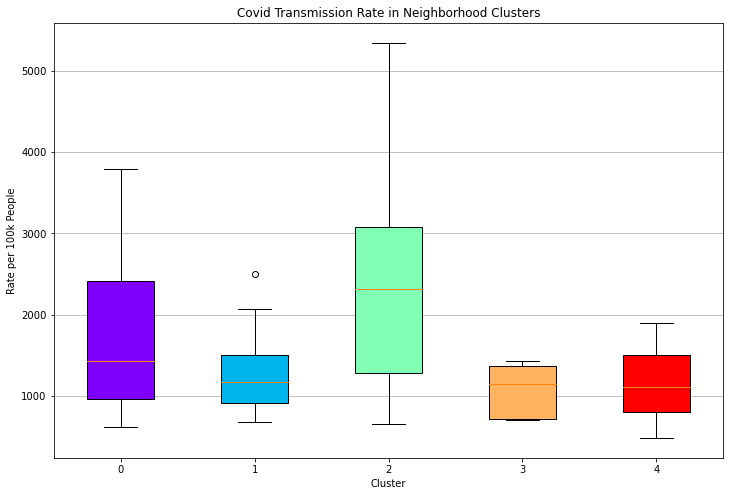

In [41]:
labels = sorted(list(toronto_merged['Cluster Labels'].unique()))
all_data = [toronto_merged.loc[toronto_merged['Cluster Labels']==label]['Rate_per_100k'].values for label in labels]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
# rectangular box plot
bplot = axes.boxplot(all_data,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
axes.set_title('Covid Transmission Rate in Neighborhood Clusters')

# fill with colors
colors_box=[]
for label in labels:
    colors_box.append(colors_array[label])

for patch, color in zip(bplot['boxes'], colors_box):
    patch.set_facecolor(color)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xlabel('Cluster')
axes.set_ylabel('Rate per 100k People')

plt.savefig('Rate_per_Cluster.png')
plt.show()

Let's use bar plot to visualize venues density in each cluster.

In [43]:
toronto_plot=toronto_grouped_nom.copy()
toronto_plot.insert(0, 'Cluster Labels', kmeans.labels_)

In [44]:
toronto_plot=toronto_plot.groupby('Cluster Labels').mean()

In [45]:
toronto_plot=toronto_plot.reset_index()

In [46]:
toronto_plot

Cluster Labels      Bank       Bar    Castle  Coffee_Shop  \
0               0  0.283403  0.219216  0.000000     0.991056   
1               1  0.273199  3.301226  0.000000     4.805692   
2               2  0.128415  0.068604  0.002869     0.378420   
3               3  0.688193  2.353837  0.000000     4.444488   
4               4  0.296411  0.827190  0.051643     2.403026   

   Distribution Center  Food_Service  Gas Station     Hotel  Indoor_Public  \
0             0.007765      3.899952     0.083110  0.051953       0.144546   
1             0.078720     12.882522     0.000000  0.281653       0.987365   
2             0.000000      1.367385     0.084202  0.030948       0.064732   
3             0.000000     22.440112     0.000000  0.172101       0.734972   
4             0.000000      8.095515     0.057444  0.064801       0.432210   

   Mobile Phone Shop    Office   Outdoor  Personal_Service  Pharmacy  \
0           0.000000  0.000000  0.519032          0.068708  0.251528   
1           0.000000  0.078965  1.362697          0.219800  0.375991   
2           0.005715  0.003153  0.648610          0.024266  0.144320   
3           0.000000  0.000000  1.230033          0.343992  0.290917   
4           0.022280  0.000000  1.111378          0.157405  0.291772   

   Rental Car Location  Sports_Place     Store  Supermarket  Transportation  
0             0.007543      0.419919  2.203011     0.107921        0.129842  
1             0.055782      1.069040  4.143176     0.045770        0.041511  
2             0.003229      0.322658  0.711161     0.048660        0.074723  
3             0.000000      2.092604  3.003483     0.320891        0.000000  
4             0.036876      0.713429  2.083265     0.044806        0.075129

Create bar plot of each cluster's venue density for all venue categories.

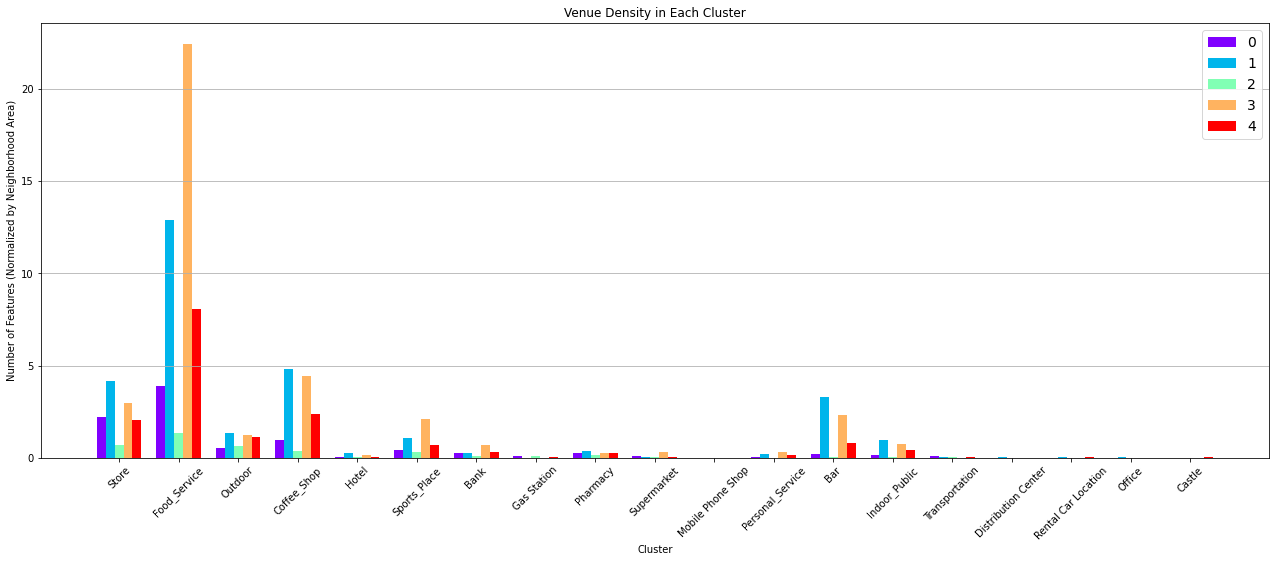

In [47]:
labels = sorted(list(toronto_plot['Cluster Labels']))
all_data = [toronto_plot.loc[toronto_plot['Cluster Labels']==label][features].values for label in labels]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,8))
# rectangular box plot
x = np.arange(len(features))  # the label locations
width = 0.15  # the width of the bars


rect0= axes.bar(x-2*width,
             list(all_data[0][0]),
             width,
             color = colors_box[0],
             label=labels[0])  # will be used to label x-ticks

rect1= axes.bar(x-width,
             list(all_data[1][0]),
             width,
             color = colors_box[1],
             label=labels[1])  # will be used to label x-ticks
rect2= axes.bar(x,
             list(all_data[2][0]),
             width,
                color = colors_box[2],
             label=labels[2])  # will be used to label x-ticks
rect3= axes.bar(x+width,
             list(all_data[3][0]),
             width,
                color = colors_box[3],
             label=labels[3])  # will be used to label x-ticks
rect4= axes.bar(x+2*width,
             list(all_data[4][0]),
             width,
                color = colors_box[4],
             label=labels[4])  # will be used to label x-ticks



axes.set_xticks(x)
axes.set_xticklabels(features, rotation=45)
axes.set_title('Venue Density in Each Cluster')
axes.legend(fontsize = 14)
# fill with colors


# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xlabel('Cluster')
axes.set_ylabel('Number of Features (Normalized by Neighborhood Area)')
plt.savefig('Venue_Density.png')

As we can see from above food service category has very high density. Let's plot another bar plot without food service so that we can see other categories better.

In [49]:
features_drop=features.copy()
features_drop.remove('Food_Service')

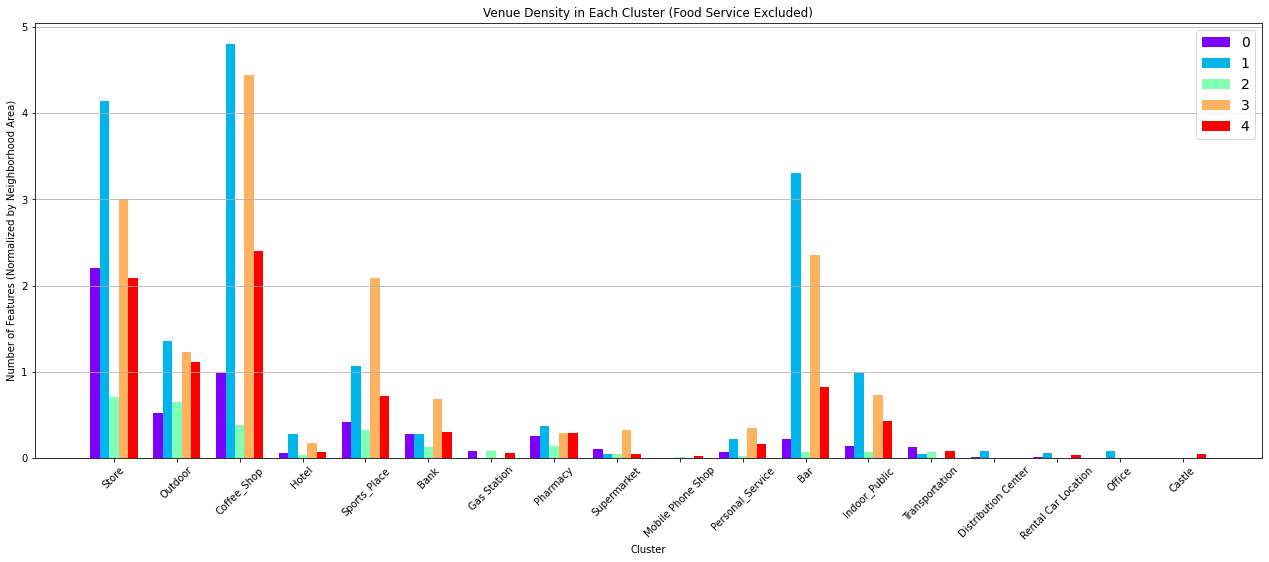

In [50]:
labels = sorted(list(toronto_plot['Cluster Labels']))
all_data = [toronto_plot.loc[toronto_plot['Cluster Labels']==label][features_drop].values for label in labels]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,8))
# rectangular box plot
x = np.arange(len(features)-1)  # the label locations
width = 0.15  # the width of the bars


rect0= axes.bar(x-2*width,
             list(all_data[0][0]),
             width,
             color = colors_box[0],
             label=labels[0])  # will be used to label x-ticks

rect1= axes.bar(x-width,
             list(all_data[1][0]),
             width,
             color = colors_box[1],
             label=labels[1])  # will be used to label x-ticks
rect2= axes.bar(x,
             list(all_data[2][0]),
             width,
                color = colors_box[2],
             label=labels[2])  # will be used to label x-ticks
rect3= axes.bar(x+width,
             list(all_data[3][0]),
             width,
                color = colors_box[3],
             label=labels[3])  # will be used to label x-ticks
rect4= axes.bar(x+2*width,
             list(all_data[4][0]),
             width,
                color = colors_box[4],
             label=labels[4])  # will be used to label x-ticks



axes.set_xticks(x)
axes.set_xticklabels(features_drop, rotation=45)
axes.set_title('Venue Density in Each Cluster (Food Service Excluded)')
axes.legend(fontsize = 14)
# fill with colors


# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xlabel('Cluster')
axes.set_ylabel('Number of Features (Normalized by Neighborhood Area)')
plt.savefig('Venue_Density_no_food.png')

## Results and Discussion <a name="results"></a>

From population density map above the population density is evenly distributed except a few neighborhoods. As we can see from the transmission rate map green and purple clusters happen to have higher transmission rate. From the map purple and green neighborhoods are located outside the core area of Toronto.  
Then we plotted each cluster's venue density for all venue categories using bar plot. Interestingly cluster green or purple does not have any venue that has significant higher density than other three clusters. In fact cluster blue and yellow have very high venue density in food service, stores, coffee shops and bars because they are at the core of city. There seems to be little correlation between venue in Toronto neighborhoods and Covid-19 transmission rate based on the analysis we performed so far. However we have to keep in mind that:  

1. We used circle of equivalent area as boundary of neighborhood instead of the real boundary.
2. Foursquare limited number of venues per API call to 50. Therefore for each neighborhood we can only obtain 50 venues.

We also have to admit that there is chance that venues in neighborhood can be indeed irrelevant to transmission rate. However we need more data and probably improved analysis method to draw a solid answer.

## Conclusion <a name="conclusion"></a>

In this report we explored the correlation between venues in Toronto neighborhood and Covid-19 transmission rate. Clustering algorithm and visualization methods such as choropleth map, box and bar plot were used to analysis data we have. We did not see strong correlation between venues in neighborhood and Covid-19 transmission rate. However this could be due to the approximation we took and the limitation of data we obtained.